In [1]:
import pandas as pd
import xgboost as xgb
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV, StratifiedKFold

from evaluation import get_cm_sklearn, print_metrics
from preprocessing import TrainingPreProcessor

RANDOM_STATE = 0

train_set = pd.read_csv("input/train.csv")

training_preprocessor = TrainingPreProcessor()
training_preprocessor.fit(train_set, ignore_columns=["CLIENTNUM"])

X, y = training_preprocessor.transform(train_set)
class_weight = training_preprocessor.class_weight

In [2]:
xgboost_model = xgb.XGBClassifier(seed=RANDOM_STATE)

## Random search

In [3]:
kfold_random = StratifiedKFold(3, shuffle=True, random_state=RANDOM_STATE)
random_parameters = {
    "n_estimators": [200, 400, 600, 800, 1000],
    "min_child_weight": [1, 3, 5, 7],
    "gamma": [0, 0.5, 1, 5, 10],
    "subsample": [0.2, 0.4, 0.6, 0.8, 1.0],
    "colsample_bytree": [0.2, 0.4, 0.6, 0.8, 1.0],
    "max_depth": [5, 6, 7, 8],
}

In [4]:
random_search = RandomizedSearchCV(
    xgboost_model,
    random_parameters,
    scoring="balanced_accuracy",
    cv=kfold_random,
    n_iter=3000,
    verbose=3,
    n_jobs=-1,
)

In [5]:
random_search.fit(X, y)
print(random_search.best_params_)
print(random_search.best_score_)
random_search.best_estimator_

Fitting 3 folds for each of 3000 candidates, totalling 9000 fits
{'subsample': 1.0, 'n_estimators': 400, 'min_child_weight': 1, 'max_depth': 5, 'gamma': 0, 'colsample_bytree': 1.0}
0.9407509993122204


XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=1.0, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=0, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=5, max_leaves=None,
              min_child_weight=1, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=400, n_jobs=None,
              num_parallel_tree=None, random_state=None, ...)

## Grid search

In [9]:
kfold = StratifiedKFold(3, shuffle=True, random_state=RANDOM_STATE)
grid_parameters = {
    "n_estimators": [300, 350, 400, 450, 500],
    "subsample": [0.8, 0.85, 0.9, 0.95, 1.0],
    "min_child_weight": [1, 2, 3],
    "gamma": [0.0, 0.05, 0.1, 0.15, 0.2],
    "colsample_bytree": [0.9, 0.95, 1.0],
    "max_depth": [4, 5, 6],
}

In [10]:
grid_search = GridSearchCV(
    xgboost_model,
    grid_parameters,
    scoring="balanced_accuracy",
    cv=kfold,
    verbose=3,
    n_jobs=-1,
)

In [11]:
grid_search.fit(X, y)
print(grid_search.best_params_)
print(grid_search.best_score_)
grid_search.best_estimator_

Fitting 3 folds for each of 3375 candidates, totalling 10125 fits
{'colsample_bytree': 1.0, 'gamma': 0.05, 'max_depth': 4, 'min_child_weight': 1, 'n_estimators': 400, 'subsample': 0.95}
0.9432721550071204


XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=1.0, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=0.05, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=4, max_leaves=None,
              min_child_weight=1, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=400, n_jobs=None,
              num_parallel_tree=None, random_state=None, ...)

In [12]:
grid_parameters = {
    "n_estimators": [350, 400, 450],
    "subsample": [0.925, 0.95, 0.975],
    "min_child_weight": [0.5, 1, 1.5],
    "gamma": [0.03, 0.05, 0.07],
    "colsample_bytree": [0.95, 0.975, 1.0],
    "max_depth": [3, 4, 5],
}

In [13]:
grid_search = GridSearchCV(
    xgboost_model,
    grid_parameters,
    scoring="balanced_accuracy",
    cv=kfold,
    verbose=3,
    n_jobs=-1,
)

In [14]:
grid_search.fit(X, y)
print(grid_search.best_params_)
print(grid_search.best_score_)
grid_search.best_estimator_

Fitting 3 folds for each of 729 candidates, totalling 2187 fits
{'colsample_bytree': 0.975, 'gamma': 0.03, 'max_depth': 3, 'min_child_weight': 0.5, 'n_estimators': 450, 'subsample': 0.975}
0.9447253982829734


XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.975, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=0.03, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=3, max_leaves=None,
              min_child_weight=0.5, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=450, n_jobs=None,
              num_parallel_tree=None, random_state=None, ...)

In [15]:
# {'colsample_bytree': 0.975, 'gamma': 0.03, 'max_depth': 3, 'min_child_weight': 0.5, 'n_estimators': 450, 'subsample': 0.975}
best_model = grid_search.best_estimator_ 

In [16]:
best_model.fit(X, y)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.975, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=0.03, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=3, max_leaves=None,
              min_child_weight=0.5, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=450, n_jobs=None,
              num_parallel_tree=None, random_state=None, ...)

In [17]:
test_set = pd.read_csv("input/test.csv")
X_test, y_test = training_preprocessor.transform(test_set)

### Avaliação do melhor modelo de floresta aleatória

Accuracy: 0.9639684106614018
Balanced Accuracy: 0.9303610866618788
F1: 0.9785483397002644
RoC AuC: 0.9303610866618788


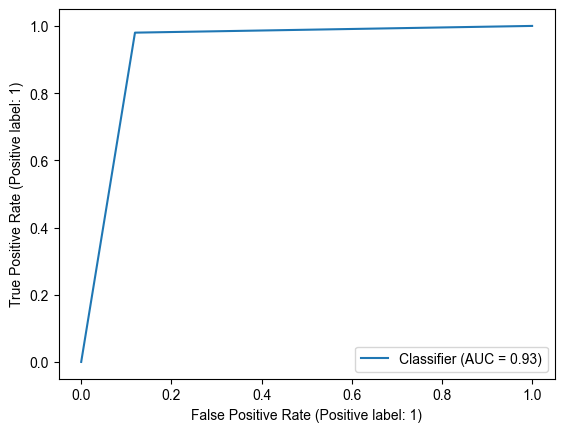

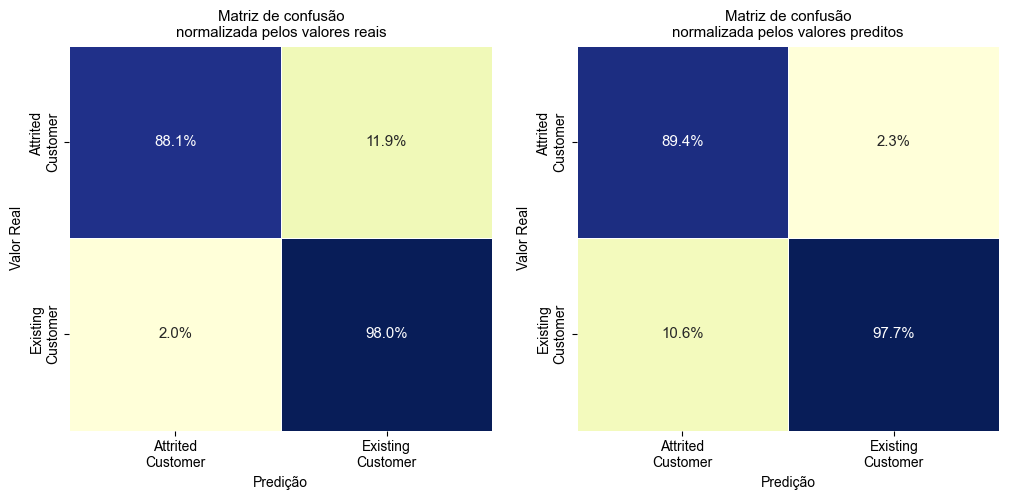

In [18]:
y_pred_test = best_model.predict(X_test)

print_metrics(y_test, y_pred_test)

get_cm_sklearn(
    y_test,
    y_pred_test,
    labels=[
        "\n".join(label.split())
        for label in training_preprocessor.label_encoder.classes_
    ],
)